In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import interp
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, label_binarize, LabelBinarizer
from sklearn.metrics import r2_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier

import lightgbm
from lightgbm import LGBMClassifier

import catboost as cb
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

### Preprocessing

Создаем выборки

In [2]:
X = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_2/3_PredictionModel/X.csv')
y = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_2/3_PredictionModel/y.csv')

X = X[['val_log',
       'sum_raised_log',
       'industry',
       'val_rate',
       'time_from_previous',
       'time_from_start',
       'top_investor_count',
       'other_investor_count',
       'Deflator',
#       '1dd_unicorn_premium'
#       '30dd_unicorn_premium'
#       '60dd_unicorn_premium'
       '90dd_unicorn_premium'
#       'cumsum_add_ritter'
#        'Deflator_1M',
#        'Deflator_3M',
#        'Deflator_6M',
#        'Deflator_9M'
      ]]

features = X.columns
features_set = []
accuracy_set = []
f1_set = []

In [3]:
# X_send = X.copy()
# X_send.columns = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9']
# X_send.to_csv('X_send_w2.csv', encoding = 'utf-8-sig')

# y_send = y.copy()
# y_send.columns = ['answer']
# y_send.to_csv('y_send_w2.csv', encoding = 'utf-8-sig')

In [4]:
X = X.values.astype(np.float) #X = X.to_numpy(dtype=np.float)
y = y.astype(int)
y = y.values.ravel() #y = y.to_numpy()
print(X.shape)
print(y.shape)

(926, 10)
(926,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

skaler = StandardScaler()
X_train_t = skaler.fit_transform(X_train)
X_test_t = skaler.transform(X_test)

### Random Forest

Sklearn

In [6]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [5, 7, 10, 20, 30, 40, 50, 75, 100],
    'min_samples_leaf': [3, 4, 5, 7, 10, 12],
    'min_samples_split': [5, 7, 10, 12, 15, 17, 20],
    'n_estimators': [25, 40, 50, 75, 100, 120, 150],
    'criterion': ["log_loss"]
}

estimator = RandomForestClassifier()
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = StratifiedKFold(n_splits=5, shuffle=True), n_jobs = -1, verbose = 2, scoring='f1')
grid_search.fit(X_train_t, y_train)
print(grid_search.best_score_)
grid_search.best_params_

Fitting 5 folds for each of 5292 candidates, totalling 26460 fits
0.7896028302536509


{'bootstrap': True,
 'criterion': 'log_loss',
 'max_depth': 10,
 'min_samples_leaf': 7,
 'min_samples_split': 10,
 'n_estimators': 40}

In [7]:
acc_array = []
f1_array = []
feature_array = []
best_grid1 = grid_search.best_estimator_
for j in range(10):
    best_grid1.fit(X_train_t, y_train)
    predicted_labels = best_grid1.predict(X_test_t)
    acc = accuracy_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels, average = 'macro')
    acc_array.append(acc)
    f1_array.append(f1)
    feature_array.append(best_grid1.feature_importances_)
print(f'acc = {np.mean(acc_array)}')
print(f'f1 = {np.mean(f1_array)}')

acc = 0.771505376344086
f1 = 0.7612629955170326


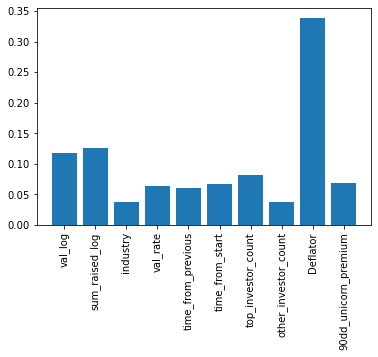

In [8]:
plt.bar(range(len(features)), best_grid1.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [9]:
accuracy_set.append(np.mean(acc_array))
f1_set.append(np.mean(f1_array))
features_set.append(np.average(feature_array, axis=0))

XGBoost

In [10]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "gamma": [0, 0.1],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [0, 0.1],
    "scale_pos_weight": [1, 3, 5],
    'max_depth': [5, 10, 25, 50, 75, 100],
    'max_leaves': [3, 5, 10, 25, 50, 100],
    'n_estimators': [50, 100, 120, 150],
    'colsample_bytree': [0.5],
    'subsample': [0.8],
    'booster': ['gbtree'],
    'objective': ["binary:logistic"],
    'eval_metric': ["logloss"]
}

estimator = XGBRFClassifier()
grid_search = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle=True), verbose = 2, scoring="f1") #, scoring='accuracy' roc_auc
grid_search.fit(X_train_t, y_train)
print(grid_search.best_score_)
grid_search.best_params_

Fitting 5 folds for each of 10368 candidates, totalling 51840 fits
0.7931837036760637


{'booster': 'gbtree',
 'colsample_bytree': 0.5,
 'eval_metric': 'logloss',
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 5,
 'max_leaves': 3,
 'n_estimators': 150,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [11]:
#best_grid2 = XGBRFClassifier(booster = 'gbtree', eval_metric = "logloss", **grid_search.best_params_)
best_grid2 = grid_search.best_estimator_
best_grid2.fit(X_train_t, y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bytree=0.5,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric='logloss', gamma=0, gpu_id=-1,
                grow_policy='depthwise', importance_type=None,
                interaction_constraints='', learning_rate=0.01, max_bin=256,
                max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
                max_leaves=3, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=150, n_jobs=0,
                num_parallel_tree=150, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0, reg_lambda=0, ...)

In [12]:
predicted_labels = best_grid2.predict(X_test_t)

roc_auc = roc_auc_score(y_test, predicted_labels)
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average = 'macro')

print(f'acc = {acc}')
print(f'f1 = {f1}')

acc = 0.7688172043010753
f1 = 0.7544441374228608


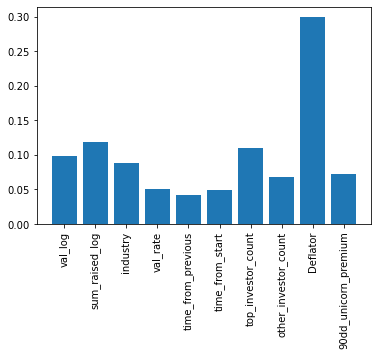

In [13]:
plt.bar(range(len(features)), best_grid2.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [14]:
accuracy_set.append(acc)
f1_set.append(f1)
features_set.append(best_grid2.feature_importances_)

### Gradient Boosting

Sklearn

In [15]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [25, 50, 75, 100],
    'min_samples_leaf': [3, 5, 7, 10],
    'min_samples_split': [5, 10, 12, 15],
    'n_estimators': [25, 50, 75, 100, 120, 150]
}

estimator = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = StratifiedKFold(n_splits=5, shuffle=True), n_jobs = -1, verbose = 2, scoring='accuracy')
grid_search.fit(X_train_t, y_train)
print(grid_search.best_score_)
grid_search.best_params_

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
0.7351351351351352


{'learning_rate': 0.05,
 'max_depth': 25,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 120}

In [16]:
acc_array = []
f1_array = []
feature_array = []
best_grid3 = grid_search.best_estimator_
for j in range(10):
    best_grid3.fit(X_train_t, y_train)
    predicted_labels = best_grid3.predict(X_test_t)
    acc = accuracy_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels, average = 'macro')
    acc_array.append(acc)
    f1_array.append(f1)
    feature_array.append(best_grid3.feature_importances_)
print(f'acc = {np.mean(acc_array)}')
print(f'f1 = {np.mean(f1_array)}')

acc = 0.7435483870967742
f1 = 0.7321045567594873


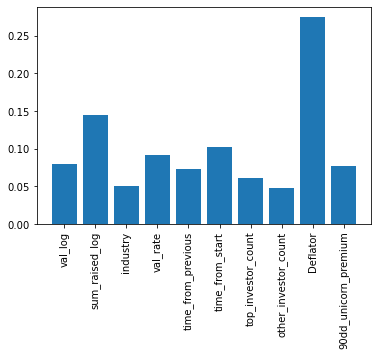

In [17]:
plt.bar(range(len(features)), best_grid3.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [18]:
accuracy_set.append(np.mean(acc_array))
f1_set.append(np.mean(f1_array))
features_set.append(np.average(feature_array, axis=0))

XGBoost

In [19]:
param_grid = {
    "max_depth": [3, 5, 10, 50, 100],
    'n_estimators': [50, 100, 120, 150],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    'objective': ["binary:logistic"],
    'colsample_bytree': [0.5],
    'subsample': [0.8]
}

estimator = XGBClassifier()
grid_search = GridSearchCV(estimator, param_grid, n_jobs=-1, verbose = 2, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring="f1") #scoring='accuracy' roc_auc
grid_search.fit(X_train_t, y_train)
print(grid_search.best_score_)
grid_search.best_params_

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
0.7888118774916641


{'colsample_bytree': 0.5,
 'gamma': 0.25,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 150,
 'objective': 'binary:logistic',
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [20]:
#pd.DataFrame(grid_search.cv_results_).to_csv('cv_results.csv')

In [21]:
# best_grid4 = XGBClassifier(colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=4, objective='binary:logistic', reg_lambda=0, scale_pos_weight=1, subsample=0.8)
# best_grid4.fit(X_train_t, y_train)
# predicted_labels = best_grid4.predict(X_test_t)

# roc_auc = roc_auc_score(y_test, predicted_labels)
# acc = accuracy_score(y_test, predicted_labels)
# f1 = f1_score(y_test, predicted_labels, average = 'macro')
# PR = precision_score(y_test, predicted_labels, average = 'macro')
# RC = recall_score(y_test, predicted_labels, average = 'macro')

# print(f'acc = {acc}')
# print(f'PR = {PR}')
# print(f'RC = {RC}')
# print(f'f1 = {f1}')

In [22]:
# sklearn.metrics.plot_confusion_matrix(best_grid4, X_test_t, y_test, xticks_rotation='horizontal', cmap='viridis', colorbar=True, normalize='true')

In [23]:
# sklearn.metrics.plot_confusion_matrix(best_grid4, X_train_t, y_train, xticks_rotation='horizontal', cmap='viridis', colorbar=True, normalize='true')

In [24]:
#best_grid4 = XGBClassifier(objective="binary:logistic", colsample_bytree = 0.5, subsample = 0.8, **grid_search.best_params_)
best_grid4 = grid_search.best_estimator_
best_grid4.fit(X_train_t, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.25, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [25]:
predicted_labels = best_grid4.predict(X_test_t)

roc_auc = roc_auc_score(y_test, predicted_labels)
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average = 'macro')

print(f'acc = {acc}')
print(f'f1 = {f1}')

acc = 0.7741935483870968
f1 = 0.760808328230251


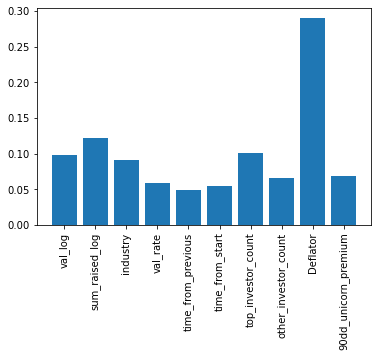

In [26]:
plt.bar(range(len(features)), best_grid4.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [27]:
accuracy_set.append(acc)
f1_set.append(f1)
features_set.append(best_grid4.feature_importances_)

LightGBM

In [28]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    'n_estimators': [25, 50, 75, 100, 120, 150],
    "reg_alpha": [0, 0.1, 0.25],
    "reg_lambda": [0, 0.1, 0.25],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
    "min_child_samples": [5, 20, 100],
    'num_leaves': [5, 20, 30, 50, 100],
    'objective': ["binary"],
    'metric': ['binary_logloss'],
    'boosting_type': ['gbdt']
}

estimator = LGBMClassifier()
grid_search = GridSearchCV(estimator, param_grid, n_jobs=-1, verbose = 2, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring="f1") #scoring='accuracy' roc_auc
grid_search.fit(X_train_t, y_train)
print(grid_search.best_score_)
grid_search.best_params_

Fitting 5 folds for each of 9720 candidates, totalling 48600 fits
0.790050802280448


{'boosting_type': 'gbdt',
 'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 3,
 'metric': 'binary_logloss',
 'min_child_samples': 5,
 'n_estimators': 100,
 'num_leaves': 20,
 'objective': 'binary',
 'reg_alpha': 0.25,
 'reg_lambda': 0.25,
 'subsample': 0.8}

In [29]:
#best_grid5 = LGBMClassifier(objective="binary", boosting_type='gbdt', **grid_search.best_params_)
best_grid5 = grid_search.best_estimator_
best_grid5.fit(X_train_t, y_train)

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.01, max_depth=3,
               metric='binary_logloss', min_child_samples=5, num_leaves=20,
               objective='binary', reg_alpha=0.25, reg_lambda=0.25,
               subsample=0.8)

In [30]:
predicted_labels = best_grid5.predict(X_test_t)

roc_auc = roc_auc_score(y_test, predicted_labels)
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average = 'macro')

print(f'acc = {acc}')
print(f'f1 = {f1}')

acc = 0.7419354838709677
f1 = 0.7096774193548387


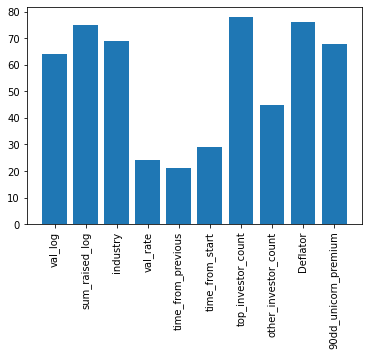

In [31]:
plt.bar(range(len(features)), best_grid5.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [32]:
accuracy_set.append(acc)
f1_set.append(f1)
features_set.append(best_grid5.feature_importances_)

### Результаты

In [33]:
accuracy_set

[0.771505376344086,
 0.7688172043010753,
 0.7435483870967742,
 0.7741935483870968,
 0.7419354838709677]

In [34]:
f1_set

[0.7612629955170326,
 0.7544441374228608,
 0.7321045567594873,
 0.760808328230251,
 0.7096774193548387]

In [35]:
features_set

[array([0.10670017, 0.12241197, 0.04367056, 0.06566778, 0.06136515,
        0.06710679, 0.08280178, 0.04290671, 0.3253424 , 0.0820267 ]),
 array([0.09901942, 0.1182257 , 0.08849324, 0.05131216, 0.04255642,
        0.04916525, 0.11051004, 0.06853944, 0.29938698, 0.0727914 ],
       dtype=float32),
 array([0.07711532, 0.14544118, 0.04929531, 0.09280425, 0.07655784,
        0.10225078, 0.06149375, 0.04482165, 0.27022015, 0.07999977]),
 array([0.09796594, 0.12196355, 0.09152958, 0.05893192, 0.04921584,
        0.05447887, 0.10141748, 0.06597217, 0.28998762, 0.06853705],
       dtype=float32),
 array([64, 75, 69, 24, 21, 29, 78, 45, 76, 68])]

In [36]:
accuracy_df = pd.DataFrame(list(zip([accuracy_set[0]], [accuracy_set[1]], [accuracy_set[2]], [accuracy_set[3]], [accuracy_set[4]])), 
               columns =['sklearn RF', 'xgboost RF', 'sklearn GB', 'XGBoost GB', 'LightGBM GB'])
f1_df = pd.DataFrame(list(zip([f1_set[0]], [f1_set[1]], [f1_set[2]], [f1_set[3]], [f1_set[4]])), 
               columns =['sklearn RF', 'xgboost RF', 'sklearn GB', 'XGBoost GB', 'LightGBM GB'])
features_df = pd.DataFrame(list(zip(features_set[0], features_set[1], features_set[2], features_set[3], features_set[4])), 
               columns =['sklearn RF', 'xgboost RF', 'sklearn GB', 'XGBoost GB', 'LightGBM GB'])
features = features.insert(0, 'ACCURACY')
features = features.insert(1, 'F1')
parameters = pd.DataFrame(list(features), columns =['Parameter'])
accuracy_df = accuracy_df.append(f1_df).reset_index(drop=True)
accuracy_df = accuracy_df.append(features_df).reset_index(drop=True)
accuracy_df = pd.concat([parameters, accuracy_df], axis=1)
accuracy_df.to_csv('results_uni_90dd.csv', encoding = 'utf-8-sig')
accuracy_df

,Parameter,sklearn RF,xgboost RF,sklearn GB,XGBoost GB,LightGBM GB
0,ACCURACY,0.771505,0.768817,0.743548,0.774194,0.741935
1,F1,0.761263,0.754444,0.732105,0.760808,0.709677
2,val_log,0.106700,0.099019,0.077115,0.097966,64.000000
3,sum_raised_log,0.122412,0.118226,0.145441,0.121964,75.000000
4,industry,0.043671,0.088493,0.049295,0.091530,69.000000
5,val_rate,0.065668,0.051312,0.092804,0.058932,24.000000
6,time_from_previous,0.061365,0.042556,0.076558,0.049216,21.000000
7,time_from_start,0.067107,0.049165,0.102251,0.054479,29.000000
8,top_investor_count,0.082802,0.110510,0.061494,0.101417,78.000000
9,other_investor_count,0.042907,0.068539,0.044822,0.065972,45.000000


### На демосетах

In [7]:
# X_DEMO = DEMO_SET.drop(columns=['exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'valuation', 'log_delta', 'top_investor', 'other_investor'])
# X_DEMO = X_DEMO[['val_log',
#         'sum_raised_log',
# #        'time_from_2009',
#         'val_rate',
#         'time_from_previous',
#         'time_from_start',
#         'top_investor_rounds',
#         'other_investor_rounds'
#         ]]

# X_DEMO = X_DEMO.values.astype(np.float)
# X_DEMO_t = skaler.transform(X_DEMO)

# X_DEMO2 = DEMO_SET2.drop(columns=['exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'valuation', 'log_delta', 'top_investor', 'other_investor'])
# X_DEMO2 = X_DEMO2[['val_log',
#         'sum_raised_log',
# #        'time_from_2009',
#         'val_rate',
#         'time_from_previous',
#         'time_from_start',
#         'top_investor_rounds',
#         'other_investor_rounds'
#         ]]

# X_DEMO2 = X_DEMO2.values.astype(np.float)
# X_DEMO2_t = skaler.transform(X_DEMO2)

# X_DEMO_ALL = DEMO_SET_ALL.drop(columns=['exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'valuation', 'log_delta', 'top_investor', 'other_investor'])
# X_DEMO_ALL = X_DEMO_ALL[['val_log',
#         'sum_raised_log',
# #        'time_from_2009',
#         'val_rate',
#         'time_from_previous',
#         'time_from_start',
#         'top_investor_rounds',
#         'other_investor_rounds'
#         ]]

# X_DEMO_ALL = X_DEMO_ALL.values.astype(np.float)
# X_DEMO_ALL_t = skaler.transform(X_DEMO_ALL)

In [20]:
# predicted_labels1 = best_grid1.predict(X_DEMO_t)
# predicted_labels2 = best_grid2.predict(X_DEMO_t)
# predicted_labels3 = best_grid3.predict(X_DEMO_t)

In [56]:
a = pd.DataFrame(list(predicted_labels1), columns =['Random_Forest'])
b = pd.DataFrame(list(predicted_labels2), columns =['Gradient_Boosting'])
c = pd.DataFrame(list(predicted_labels3), columns =['XGBoost_Classifier'])
demo = pd.concat([DEMO_SET[['company_name']].reset_index(drop=True), a, b, c], axis=1)
#demo.to_csv('forecast_w2.csv', encoding = 'utf-8-sig')
demo

,company_name,Random_Forest,Gradient_Boosting,XGBoost_Classifier
0,Roblox Corporation,0.0,0.0,1.0
1,Lemonade,1.0,1.0,1.0
2,Palantir Technologies,1.0,1.0,1.0
3,DoorDash,1.0,1.0,1.0
4,JFrog,1.0,0.0,1.0
5,Unity Technologies,1.0,1.0,1.0
6,Sumo Logic,1.0,1.0,1.0
7,Snowflake Computing,1.0,1.0,1.0
8,Airbnb,1.0,1.0,1.0
9,Asana,1.0,1.0,1.0


In [21]:
# predicted_labels1 = best_grid1.predict(X_DEMO2_t)
# predicted_labels2 = best_grid2.predict(X_DEMO2_t)
# predicted_labels3 = best_grid3.predict(X_DEMO2_t)

In [58]:
a = pd.DataFrame(list(predicted_labels1), columns =['Random_Forest'])
b = pd.DataFrame(list(predicted_labels2), columns =['Gradient_Boosting'])
c = pd.DataFrame(list(predicted_labels3), columns =['XGBoost_Classifier'])
demo = pd.concat([DEMO_SET2[['company_name']].reset_index(drop=True), a, b, c], axis=1)
#demo.to_csv('forecast_w2_2.csv', encoding = 'utf-8-sig')
demo

,company_name,Random_Forest,Gradient_Boosting,XGBoost_Classifier
0,VertiFlex,1.0,1.0,1.0
1,mitú,1.0,1.0,1.0
2,Postmates,1.0,1.0,1.0
3,Calient Technologies,0.0,1.0,1.0
4,Kyriba Corporation,1.0,0.0,0.0
5,Vidyo,0.0,0.0,1.0
6,littleBits Electronics,1.0,1.0,1.0
7,Harry's,1.0,1.0,1.0
8,Numerify,1.0,1.0,1.0
9,Whistle Sports,1.0,1.0,1.0


In [22]:
# predicted_labels1 = best_grid1.predict(X_DEMO_ALL_t)
# predicted_labels2 = best_grid2.predict(X_DEMO_ALL_t)
# predicted_labels3 = best_grid3.predict(X_DEMO_ALL_t)

In [60]:
a = pd.DataFrame(list(predicted_labels1), columns =['Random_Forest'])
b = pd.DataFrame(list(predicted_labels2), columns =['Gradient_Boosting'])
c = pd.DataFrame(list(predicted_labels3), columns =['XGBoost_Classifier'])
demo = pd.concat([DEMO_SET_ALL[['company_name']].reset_index(drop=True), a, b, c], axis=1)
demo.to_csv('forecast_w2_all.csv', encoding = 'utf-8-sig')
demo

,company_name,Random_Forest,Gradient_Boosting,XGBoost_Classifier
0,BioAtla LLC,0.0,0.0,1.0
1,Lot18,0.0,0.0,0.0
2,Xcovery,0.0,0.0,0.0
3,HeartFlow,1.0,1.0,1.0
4,Udacity,1.0,1.0,1.0
...,...,...,...,...
2382,PowerVision,0.0,0.0,0.0
2383,Sisense,1.0,1.0,1.0
2384,IlluminOss Medical,0.0,0.0,0.0
2385,Checkr,1.0,1.0,1.0


### На единичных признаках

In [23]:
# y = dataset[['not_dead']]
# y = y.values.ravel()
# X_general = dataset.drop(columns=['class', 'not_dead', 'exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'valuation', 'log_delta', 'top_investor', 'other_investor'])

# skaler = StandardScaler()
# param_grid = {
#     'bootstrap': [True, False], #rf only
# #    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], #boosting only
#     'max_depth': [None, 25, 50, 75, 100],
#     'min_samples_leaf': [1, 2, 3],
#     'min_samples_split': [2, 5, 10],
#     'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
# }
# estimator = RandomForestClassifier() #0.65-0.71
# #estimator = GradientBoostingClassifier() #0.6-0.66
# grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, scoring='accuracy')

# X_general.columns

In [24]:
# mean_acc = []
# mean_f1 = []
# features = ['time_from_2009', 'time_from_start', 'time_from_previous',
#        'top_investor_count', 'other_investor_count', 'top_investor_sum',
#        'other_investor_sum', 'top_investor_rounds', 'other_investor_rounds',
#        'sum_raised_log', 'val_log', 'val_rate']
# for i in features:
#     X = X_general[[i]]
#     X = X.values.astype(np.float)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#     X_train_t = skaler.fit_transform(X_train)
#     X_test_t = skaler.transform(X_test)
#     grid_search.fit(X_train_t, y_train)
#     best_grid = grid_search.best_estimator_
    
#     acc_array = []
#     f1_array = []
#     PR_array = []
#     RC_array = []
#     for j in range(10):
#         best_grid.fit(X_train_t, y_train)
#         predicted_labels = best_grid.predict(X_test_t)
#         acc = accuracy_score(y_test, predicted_labels)
#         f1 = f1_score(y_test, predicted_labels, average = 'macro')
#         PR = precision_score(y_test, predicted_labels, average = 'macro')
#         RC = recall_score(y_test, predicted_labels, average = 'macro')
#         acc_array.append(acc)
#         PR_array.append(PR)
#         RC_array.append(RC)
#         f1_array.append(f1)
#     mean_acc.append(np.mean(acc_array))
#     mean_f1.append(np.mean(f1_array))
#     #print(f'acc on {i} = {np.mean(acc_array)}')
#     #print(f'f1 on {i} = {np.mean(f1_array)}')
# mean_acc_f1_df = pd.DataFrame(list(zip(mean_acc, mean_f1)), 
#                columns =['Accuracy', 'F-Score']).set_index([features])
# print(mean_acc_f1_df)

In [35]:
mean_acc_f1_df

,Accuracy,F-Score
time_from_2009,0.561538,0.557030
time_from_start,0.503077,0.496843
time_from_previous,0.518462,0.507093
top_investor_count,0.620513,0.615159
other_investor_count,0.584103,0.549638
top_investor_sum,0.548718,0.546877
other_investor_sum,0.527692,0.507549
top_investor_rounds,0.579487,0.526923
other_investor_rounds,0.602051,0.559214
total_sum_raised_before,0.567179,0.540938


In [76]:
# acc_train = []
# acc_test = []
# f1_train = []
# f1_test = []
# for i in range(1, 101):
#     #classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100, C=0.12, penalty='l1', n_jobs=-1) #меньше 0.6
#     #classifier = KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs =-1) #отвратительное качество
#     classifier = DecisionTreeClassifier(max_depth=100) #качество на уровне 0.65-0.7
    
#     #ensemble_classifier = BaggingClassifier(base_estimator=classifier, n_estimators=i, bootstrap=True, n_jobs=-1)
#     ensemble_classifier = RandomForestClassifier(n_estimators=i, n_jobs=-1) #качество на уровне 0.65-0.7
#     #ensemble_classifier = GradientBoostingClassifier(n_estimators=i, learning_rate=0.2, max_depth=10) #качество на уровне 0.6-0.7
    
#     ensemble_classifier.fit(X_train_t, y_train)
#     class_names = ensemble_classifier.classes_
#     y_train_b = label_binarize(y_train, class_names)
#     y_test_b = label_binarize(y_test, class_names)
#     y_predict_train_b = label_binarize(ensemble_classifier.predict(X_train_t), class_names)
#     y_predict_test_b = label_binarize(ensemble_classifier.predict(X_test_t), class_names)
#     acc_train.append(accuracy_score(y_train_b, y_predict_train_b))
#     f1_train.append(f1_score(y_train_b, y_predict_train_b, average='weighted'))
#     acc_test.append(accuracy_score(y_test_b, y_predict_test_b))
#     f1_test.append(f1_score(y_test_b, y_predict_test_b, average='weighted'))

# plt.figure(figsize=(7, 7))
# plt.plot(np.arange(1, 101), acc_train, label='accuracy train')
# plt.plot(np.arange(1, 101), f1_train, label='f1_score train')
# plt.plot(np.arange(1, 101), acc_test, label='accuracy test')
# plt.plot(np.arange(1, 101), f1_test, label='f1_score test')
# plt.xlabel('n_estimators')
# plt.ylabel('score')
# plt.legend()
# plt.grid()
# plt.show()

### LogReg, kNN, Decision Tree

In [17]:
#pg = {'C': np.linspace(0.01, 1, 10), 'penalty': ['l1', 'l2']}
#pg = {'n_neighbors': range(1, 21)}
#pg = {'max_depth': np.linspace(1, 100, 5)}

#classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=1000, n_jobs =-1) #lbfgs
#classifier = KNeighborsClassifier(weights='distance')
#classifier = DecisionTreeClassifier()

#grid_search = GridSearchCV(estimator=classifier, n_jobs = -1, param_grid=pg, cv=5, scoring='accuracy')
#grid_search.fit(X_train_t, y_train)

#grid_search.best_params_

In [18]:
#best_classifier = grid_search.best_estimator_
#best_classifier.fit(X_train_t, y_train)

In [19]:
#predicted_labels = best_classifier.predict(X_test_t)

#acc = accuracy_score(y_test, predicted_labels)
#print(f'acc = {acc}')
#f1 = f1_score(y_test, predicted_labels, average = 'macro')
#print(f'f1 = {f1}')

In [20]:
#predict_proba = grid_search.predict_proba(X_test_t)
#for i in predict_proba:
#    print(i)

In [21]:
#class_names = grid_search.best_estimator_.classes_
#y_predict = grid_search.predict_proba(X_test_t)

##y_test_b = label_binarize(y_test, class_names)
#lb = LabelBinarizer()
#y_test_b = lb.fit_transform(y_test)
#y_test_b = np.hstack((1 - y_test_b, y_test_b))

#fpr = dict()
#tpr = dict()
#roc_auc = dict()
#for i in range(len(class_names)):
#    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_predict[:, i])
#    roc_auc[i] = auc(fpr[i], tpr[i])
    
##для микро
#fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_predict.ravel())
#roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

##макро
#all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
#mean_tpr = np.zeros_like(all_fpr)
#for i in range(len(class_names)):
#    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
#mean_tpr /= len(class_names)
#fpr['macro'] = all_fpr
#tpr['macro'] = mean_tpr
#roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

##графики
#plt.figure(figsize=(6,6))
#plt.plot(fpr['micro'], tpr['micro'], label='micro, auc = %.3f'%(roc_auc['micro']), linestyle='--')
#plt.plot(fpr['macro'], tpr['macro'], label='macro, auc = %.3f'%(roc_auc['macro']), linestyle='--')
#for i in range(len(class_names)):
#    plt.plot(fpr[i], tpr[i], label='class = %s, auc = %.3f'%(class_names[i], auc(fpr[i], tpr[i])))

#plt.title('ROC-Кривая')
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.legend()
#plt.show()

### Сокращение размерности

In [34]:
#pca = PCA()
#pca.fit(X_train_t)

#variance = np.cumsum(pca.explained_variance_ratio_)

#plt.figure(figsize=(5,5))
#plt.plot(variance)
#plt.xlabel('Components')
#plt.ylabel('EVR')
#plt.plot([0,46],[0.95,0.95])
#plt.show()

In [35]:
#pca = PCA(n_components=39)

#X_train_pca = pca.fit_transform(X_train_t)
#X_test_pca = pca.transform(X_test_t)

In [36]:
#pg = {'C': np.linspace(0.01, 1, 10), 'penalty': ['l1', 'l2']}
#pg = {'n_neighbors': range(1, 31)}
#pg = {'max_depth': np.linspace(1, 100, 5)}

In [37]:
#classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100, n_jobs =-1) #lbfgs
#classifier = KNeighborsClassifier(weights='distance')
#classifier = DecisionTreeClassifier()

#grid_search = GridSearchCV(estimator=classifier, n_jobs = -1, param_grid=pg, cv=5, scoring='accuracy')
#grid_search.fit(X_train_pca, y_train)

#grid_search.best_params_

In [38]:
#predicted_labels = grid_search.predict(X_test_pca)

#acc = accuracy_score(y_test, predicted_labels)
#f1 = f1_score(y_test, predicted_labels, average='weighted')
#print('acc = ', acc)
#print('f1 = ', f1)

### Catboost

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

skaler = StandardScaler()
X_train_t = skaler.fit_transform(X_train)
X_eval_t = skaler.fit_transform(X_eval)
X_test_t = skaler.transform(X_test)

In [64]:
model = CatBoostClassifier(has_time=True, iterations=1000, depth=10, learning_rate=0.1, loss_function='CrossEntropy')
model.fit(X_train_t, y_train, eval_set=(X_eval_t, y_eval), verbose=100)

print ('CatBoost: prediction of %s: RMSLE on test = %s' % ('not_dead', model.evals_result_['validation']['CrossEntropy'][-1]))

0:	learn: 0.6514671	test: 0.6741755	best: 0.6741755 (0)	total: 155ms	remaining: 2m 34s
100:	learn: 0.0489779	test: 0.6215706	best: 0.5913487 (16)	total: 1.58s	remaining: 14.1s
200:	learn: 0.0177040	test: 0.6744059	best: 0.5913487 (16)	total: 2.9s	remaining: 11.6s
300:	learn: 0.0101371	test: 0.7124593	best: 0.5913487 (16)	total: 4.2s	remaining: 9.76s
400:	learn: 0.0069237	test: 0.7399347	best: 0.5913487 (16)	total: 5.55s	remaining: 8.29s
500:	learn: 0.0053840	test: 0.7578491	best: 0.5913487 (16)	total: 6.87s	remaining: 6.84s
600:	learn: 0.0044076	test: 0.7763442	best: 0.5913487 (16)	total: 8.21s	remaining: 5.45s
700:	learn: 0.0038291	test: 0.7896251	best: 0.5913487 (16)	total: 9.62s	remaining: 4.1s
800:	learn: 0.0033698	test: 0.7988073	best: 0.5913487 (16)	total: 10.9s	remaining: 2.72s
900:	learn: 0.0030590	test: 0.8067507	best: 0.5913487 (16)	total: 12.3s	remaining: 1.35s
999:	learn: 0.0028825	test: 0.8127623	best: 0.5913487 (16)	total: 13.7s	remaining: 0us

bestTest = 0.5913486676
bes

In [65]:
y_pred = model.predict(X_test_t)
y_pred

array([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
      dtype=int64)

In [66]:
y_test = y_test.values.ravel()
y_test

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.])

In [67]:
print(model.get_feature_importance(type=cb.EFstrType.PredictionValuesChange, prettified=True).head(25).to_string())
print(model.score(X_test_t, y_test))


CatBoost: prediction of log_delta. Feature importance. Type=PredictionValuesChange
  Feature Id  Importances
0          6    19.197516
1          3    18.696240
2          0    17.847655
3          7    12.064020
4          2     9.962412
5          4     8.120351
6          5     7.730078
7          1     6.381729


### SelectKBest

In [8]:
# selector = SelectKBest(f_classif, k='all')
# selector.fit(X_train_t, y_train)

# #самый большой результат соответствует самому малому значению p-значения(вероятность ошибки)
# #поэтому "переворачиваем", чтоб самые ценные признаки на графике были максимальными
# scores = -np.log10(selector.pvalues_)

# plt.bar(range(len(features)), scores)
# plt.xticks(range(len(features)), features, rotation='vertical')
# plt.show()